In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)
import os
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import requests
import pandas as pd
import seaborn as sns


In [2]:
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, "..", "..", "data")

In [3]:

# fetch statistics (health, mana, etc) for a character
def get_champion_data(version, champ_name):

    # no api key needed
    url = f"https://ddragon.leagueoflegends.com/cdn/{version}/data/en_US/champion/{champ_name}.json"
    data = requests.get(url).json()["data"]
    for champ_name, champ_info in data.items():
        stats = {key: item for key, item in champ_info["stats"].items() if key not in ["crit", "critperlevel"]}
        info = {key: item for key, item in champ_info["info"].items() if key != "difficulty"}
        row = {
            **info,
            **stats
        }
    return list(row.values())
    


In [4]:
# for a champuion, return the vector embedding
champion_vector_mapping = {}
VERSION = "15.23.1"

def get_champion_vector(champ_name):
    if champ_name not in champion_vector_mapping:
        try:
            champion_vector_mapping[champ_name] = get_champion_data(VERSION, champ_name)
        except:
            champion_vector_mapping[champ_name] = [0] * 21
    return champion_vector_mapping[champ_name]

champ_cols = [
    "BLUE_TOP","BLUE_JUNGLE","BLUE_MIDDLE","BLUE_BOTTOM","BLUE_UTILITY",
    "RED_TOP","RED_JUNGLE","RED_MIDDLE","RED_BOTTOM","RED_UTILITY"
]
def row_to_vector(row):
    vectors = []
    for col in champ_cols:
        champ = row[col]
        vectors.extend(get_champion_vector(champ))
    return vectors



In [5]:
get_champion_data("15.23.1","Fiddlesticks") # test it out

[2,
 3,
 9,
 650,
 106,
 500,
 28,
 335,
 34,
 4.7,
 30,
 1.3,
 480,
 5.5,
 0.6,
 8,
 0.8,
 55,
 2.65,
 2.11,
 0.625]

In [6]:
df = pd.read_csv(os.path.join(data_dir, "sai_preprocessed_data","preprocessed_matches.csv")) # read file from data_preprocessing.ipynb
df

,BLUE_TOP,BLUE_JUNGLE,BLUE_MIDDLE,BLUE_BOTTOM,BLUE_UTILITY,RED_WINNER,RED_TOP,RED_JUNGLE,RED_MIDDLE,RED_BOTTOM,RED_UTILITY
0,Rumble,Zyra,Zed,Kaisa,Poppy,False,Yone,Kindred,Cassiopeia,Ziggs,Rell
1,Jax,Syndra,Swain,Twitch,Sion,False,Olaf,Diana,Taliyah,Smolder,Karma
2,Fiora,Trundle,Sylas,Anivia,Poppy,True,Cassiopeia,Nocturne,Hwei,Caitlyn,Neeko
3,Ornn,Viego,Syndra,Ezreal,Leona,True,Cassiopeia,Naafiri,Sylas,Ziggs,Senna
4,KSante,Nocturne,Anivia,Syndra,Alistar,False,Ambessa,Lillia,Ryze,Sivir,Bard
...,...,...,...,...,...,...,...,...,...,...,...
14276,Camille,Gragas,Yasuo,Seraphine,Nautilus,True,Jax,Lillia,Tristana,Samira,Alistar
14277,Vayne,Gragas,Corki,Twitch,Nami,False,Fiora,XinZhao,Sylas,Varus,Hwei
14278,Camille,Elise,Draven,Jinx,Janna,False,Malphite,Khazix,Cassiopeia,Jhin,Thresh
14279,Aatrox,Volibear,Leblanc,Brand,Thresh,False,Kennen,RekSai,Lissandra,MissFortune,Leona


In [7]:
X = df.apply(row_to_vector, axis=1, result_type="expand")  # encode each character name to its corresponding vector
y = df["RED_WINNER"].astype(int) # binary classification

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Feature matrix shape: (14281, 210)
Target vector shape: (14281,)


In [8]:
X

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
0,3.0,6.0,8.0,655.0,105.0,150.0,0.0,345.0,36.0,4.7,...,1.80,175.0,7.5,0.85,7.0,0.70,55.0,3.00,2.000,0.625
1,7.0,5.0,7.0,650.0,103.0,339.0,52.0,350.0,36.0,4.2,...,1.30,525.0,5.5,0.55,13.0,0.80,51.0,3.30,2.300,0.625
2,10.0,4.0,2.0,620.0,99.0,300.0,60.0,345.0,33.0,4.7,...,1.30,550.0,7.5,0.75,7.0,0.70,48.0,2.50,3.500,0.625
3,5.0,9.0,3.0,660.0,109.0,341.0,65.0,335.0,33.0,5.2,...,1.30,600.0,3.5,0.55,11.5,0.70,50.0,0.00,2.600,0.625
4,8.0,8.0,7.0,625.0,120.0,320.0,60.0,330.0,36.0,5.2,...,1.30,500.0,5.5,0.55,6.0,0.45,52.0,3.00,2.000,0.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14276,8.0,6.0,3.0,650.0,99.0,339.0,52.0,340.0,35.0,4.5,...,2.05,125.0,8.5,0.85,8.5,0.80,62.0,3.75,2.125,0.625
14277,10.0,1.0,1.0,550.0,103.0,232.0,35.0,330.0,23.0,4.6,...,1.30,550.0,5.5,0.55,7.5,0.75,54.0,3.30,2.500,0.690
14278,8.0,6.0,3.0,650.0,99.0,339.0,52.0,340.0,35.0,4.5,...,1.55,450.0,7.0,0.55,6.0,0.80,56.0,2.20,3.500,0.625
14279,8.0,4.0,3.0,650.0,114.0,0.0,0.0,345.0,38.0,4.8,...,2.05,125.0,8.5,0.85,6.0,0.80,60.0,3.00,2.900,0.625


In [9]:
X.isna().sum().sum() # no empty vals

np.int64(0)

In [10]:
df['RED_WINNER'].value_counts()  # relatively even distribution

RED_WINNER
False    7395
True     6886
Name: count, dtype: int64

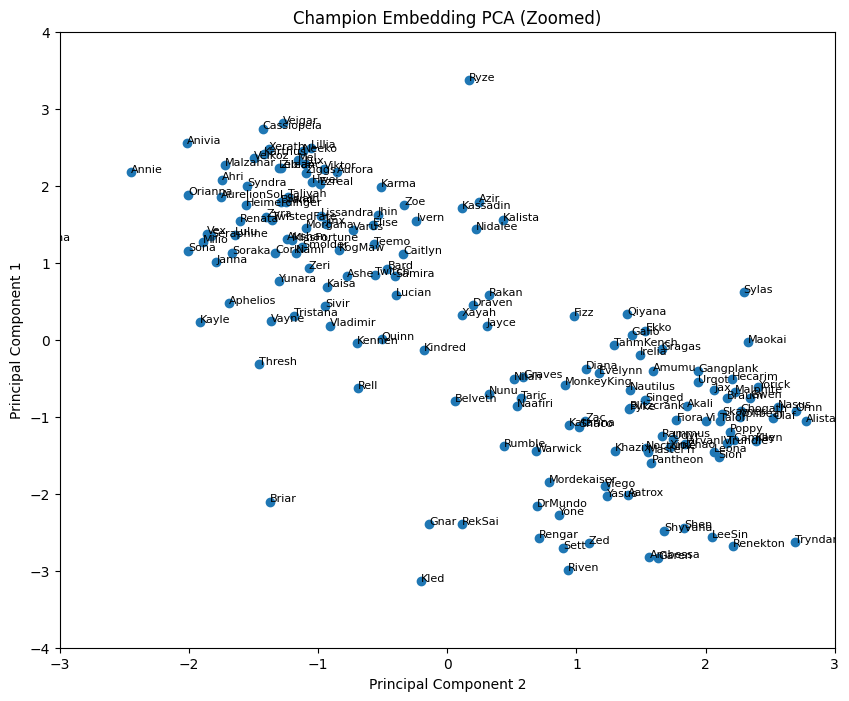

In [11]:
# pca to understand how accurate my vector embeddings are
vecs = np.array(list(champion_vector_mapping.values()))
names = np.array(list(champion_vector_mapping.keys()))

scaler = StandardScaler()
scaled = scaler.fit_transform(vecs)


pca = PCA(n_components=2)
coords = pca.fit_transform(scaled)
plt.figure(figsize=(10,8))

plt.scatter(coords[:,0], coords[:,1])
for name,(x,y_) in zip(names, coords):
    plt.text(x, y_, name, fontsize=8, clip_on=True)


plt.xlim(-3, 3)  
plt.ylim(-4, 4) 
plt.ylabel("Principal Component 1")
plt.xlabel("Principal Component 2")


plt.gca().set_autoscale_on(False)
plt.title("Champion Embedding PCA (Zoomed)")
plt.show()





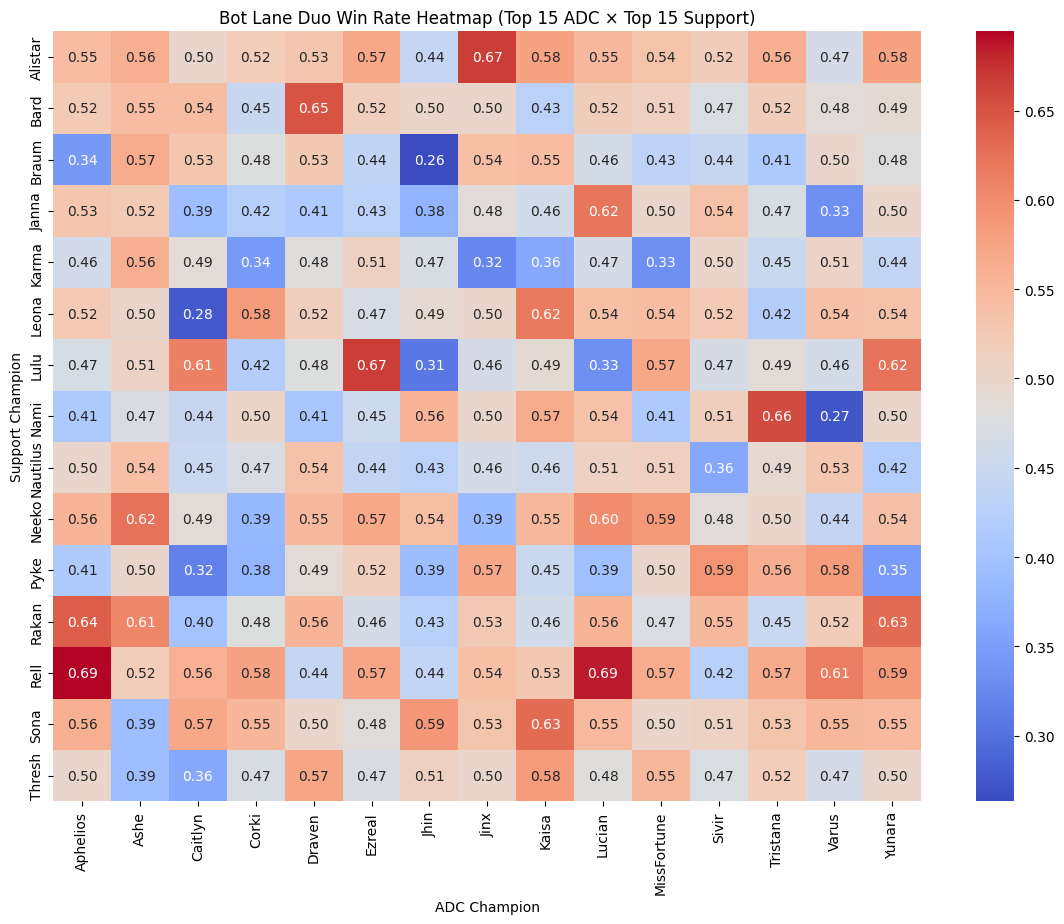

In [12]:
rows = []

# winrate for combination of ADC + UTILITY pairs out of curiousity

for _, row in df.iterrows():
    rows.append({
        "ADC": row["RED_BOTTOM"],
        "SUPPORT": row["RED_UTILITY"],
        "WIN": row["RED_WINNER"]
    })
    rows.append({
        "ADC": row["BLUE_BOTTOM"],
        "SUPPORT": row["BLUE_UTILITY"],
        "WIN": 1 - row["RED_WINNER"]
    })

bot_sup_pairs = pd.DataFrame(rows)
bot_sup_pairs["WIN"] = bot_sup_pairs["WIN"].astype(float)

adc_counts = bot_sup_pairs["ADC"].value_counts()
sup_counts = bot_sup_pairs["SUPPORT"].value_counts()

top_N_adc = adc_counts.head(15).index
top_N_sup = sup_counts.head(15).index

pivot = bot_sup_pairs.pivot_table(
    index="SUPPORT",
    columns="ADC",
    values="WIN",
    aggfunc="mean"
)

valid_adc = pivot.columns.intersection(top_N_adc)
valid_sup = pivot.index.intersection(top_N_sup)

pivot_small = pivot.loc[valid_sup, valid_adc]

plt.figure(figsize=(14,10))
sns.heatmap(pivot_small, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Bot Lane Duo Win Rate Heatmap (Top 15 ADC × Top 15 Support)")
plt.xlabel("ADC Champion")
plt.ylabel("Support Champion")
plt.show()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
len(y_test)

2857

In [15]:
gb = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4],
    'subsample': [0.8, 1.0]
}

gb_grid = GridSearchCV(
    gb,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

gb_grid.fit(X_train, y_train)

gb_pred = gb_grid.predict(X_test)

print("\nBest parameters:", gb_grid.best_params_)
print("Best CV accuracy:", gb_grid.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV accuracy: 0.5358018207282913


In [16]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200, 400, 600],  
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

rf_grid = GridSearchCV(
    rfc,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

rf_pred = rf_grid.predict(X_test)

print("\nBest parameters:", rf_grid.best_params_)
print("Best CV accuracy:", rf_grid.best_score_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits



Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
Best CV accuracy: 0.5340511204481793


In [17]:
print("Gradient Boosting Accuracy:", accuracy_score(y_test, gb_pred))
print("Gradient Boosting Precision:", precision_score(y_test, gb_pred, average='weighted'))
print("Gradient Boosting Recall:", recall_score(y_test, gb_pred, average='weighted'))
print("Gradient Boosting F1 Score:", f1_score(y_test, gb_pred, average='weighted'))


Gradient Boosting Accuracy: 0.5250262513125656
Gradient Boosting Precision: 0.5221070163563138
Gradient Boosting Recall: 0.5250262513125656
Gradient Boosting F1 Score: 0.5146536278816881


In [18]:
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))
print("Random Forest Precision:", precision_score(y_test, rf_pred, average='weighted'))
print("Random Forest Recall:", recall_score(y_test, rf_pred, average='weighted'))
print("Random Forest F1 Score:", f1_score(y_test, rf_pred, average='weighted'))


Random Forest Accuracy: 0.5302765138256913
Random Forest Precision: 0.5277535217284747
Random Forest Recall: 0.5302765138256913
Random Forest F1 Score: 0.5143193017794497


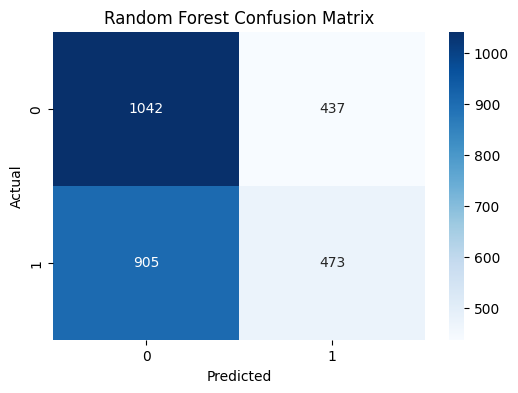

In [19]:
r_c = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(r_c, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


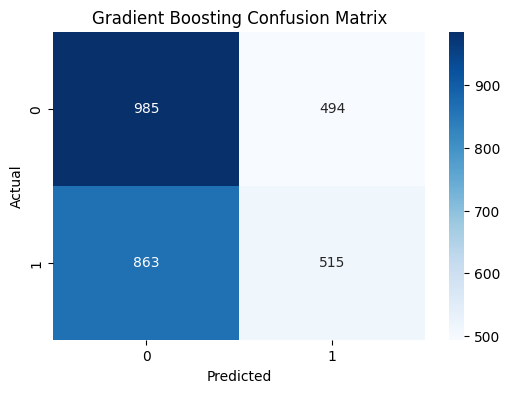

In [20]:

g_c = confusion_matrix(y_test, gb_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(g_c, annot=True, fmt='d', cmap='Blues')
plt.title("Gradient Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


From these visualizations and metrics, we can conclude that the machine learning pipeline I have created here does not work too well, as it is only slightly above 50%, which is like a coin toss. The confusion matrices demonstrate that the model tends to predict 0 (or red loss) more often, which can be explained by the fact that the test set has somewhat more points with a 0 label than 1 label. This result of low prediction power is pretty expected, as games are decided by (I'd say) millions of other factors, and draft is just one, major factor that contributes to whoever wins a game. 